**Experiment 8** : Implement Recurrent Neural Networks for suitable application using Gated Recurrent Units (GRUs).

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import plotly.express as px

**Performance Evaluation**

In [27]:
from sklearn import metrics

title_name = []
r2_score = []
mae = []
mse = []
acc = []

def evaluate(y_actual, y_predicted, title):
    errors = abs(y_predicted - y_actual)
    mape = 100 * np.mean(errors / y_actual)
    accuracy = 100 - mape
    
    title_name.append(title)
    r2_score.append(metrics.r2_score(y_actual, y_predicted))
    mae.append(metrics.mean_absolute_error(y_actual, y_predicted))
    mse.append(metrics.mean_squared_error(y_actual, y_predicted))
    acc.append(round(accuracy, 2))

**DataSet 1** : Stock Price

In [5]:
stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04 00:00:00-05:00,25.652500,26.342501,25.500000,26.337500,24.151495,270597600
2016-01-05 00:00:00-05:00,26.437500,26.462500,25.602501,25.677500,23.546274,223164000
2016-01-06 00:00:00-05:00,25.139999,25.592501,24.967501,25.174999,23.085485,273829600
2016-01-07 00:00:00-05:00,24.670000,25.032499,24.107500,24.112499,22.111170,324377600
2016-01-08 00:00:00-05:00,24.637501,24.777500,24.190001,24.240000,22.228090,283192000
...,...,...,...,...,...,...
2021-09-24 00:00:00-04:00,145.660004,147.470001,145.559998,146.919998,146.101303,53477900
2021-09-27 00:00:00-04:00,145.470001,145.960007,143.820007,145.369995,144.559937,74150700
2021-09-28 00:00:00-04:00,143.250000,144.750000,141.690002,141.910004,141.119232,108972300


Text(0, 0.5, 'Prices ($)')

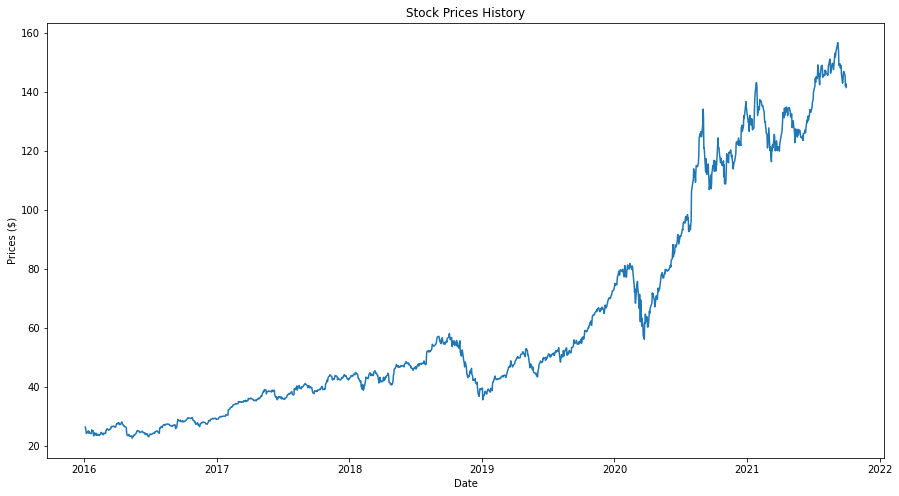

In [6]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [7]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

In [8]:
def change_step(x):
  x_train = []
  y_train = []

  for i in range(x, len(train_data)):
      x_train.append(train_data[i-x:i, 0])
      y_train.append(train_data[i, 0])
      
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  test_data = scaled_data[training_data_len-x: , : ]
  x_test = []
  y_test = values[training_data_len:]

  for i in range(x, len(test_data)):
    x_test.append(test_data[i-x:i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  return x_train, y_train, x_test, y_test

In [9]:
def model(x_train):
  model = keras.Sequential(name="GRU-Model")
  model.add(layers.GRU(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(layers.GRU(100, return_sequences=False))
  model.add(layers.Dense(25))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

In [39]:
def predictions(model, x_train, y_train, x_test):
  model.fit(x_train, y_train, batch_size= 1, epochs=3)
  predictions = model.predict(x_test)

  return predictions

In [11]:
def prediction_visualization(y_predicted):
  data = stock_data.filter(['Close'])
  train = data[:training_data_len]
  validation = data[training_data_len:]
  validation['Predictions'] = y_predicted
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date')
  plt.ylabel('Close Price USD ($)')
  plt.plot(train)
  plt.plot(validation[['Close', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()

In [12]:
x_train, y_train, x_test, y_test = change_step(60)
model1 = model(x_train)
model1.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 100)           30900     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 94,051
Trainable params: 94,051
Non-trainable params: 0
_________________________________________________________________


In [13]:
y_predicted = predictions(model1, x_train, y_train, x_test)

Epoch 1/3
1098/1098 [==============================] - 22s 11ms/step - loss: 5.9981e-04
Epoch 2/3
1098/1098 [==============================] - 9s 8ms/step - loss: 2.5720e-04
Epoch 3/3
1098/1098 [==============================] - 9s 8ms/step - loss: 2.8322e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


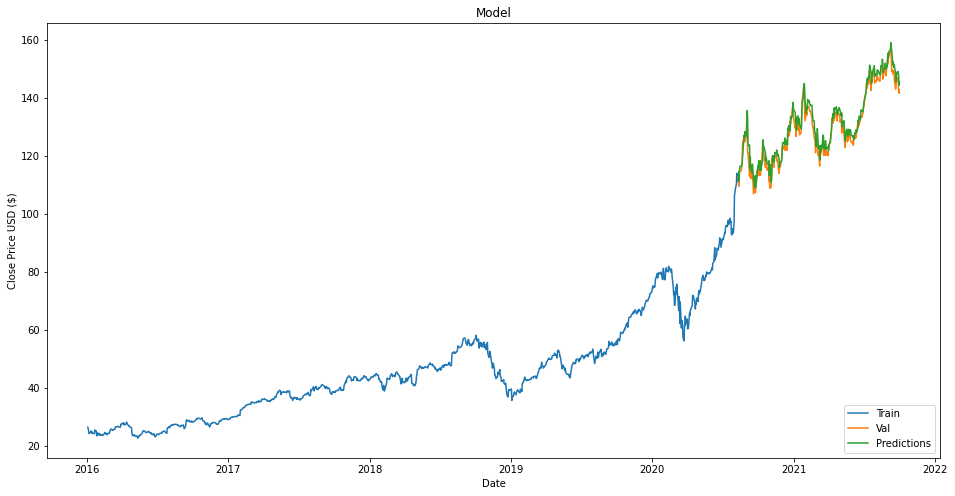

In [14]:
evaluate(y_test, y_predicted, '60 Steps')
prediction_visualization(y_predicted)

In [15]:
x_train, y_train, x_test, y_test = change_step(30)
model2 = model(x_train)
model2.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 100)           30900     
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 94,051
Trainable params: 94,051
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_predicted = predictions(model2, x_train, y_train, x_test)

Epoch 1/3
1128/1128 [==============================] - 8s 6ms/step - loss: 6.5602e-04
Epoch 2/3
1128/1128 [==============================] - 6s 6ms/step - loss: 2.8850e-04
Epoch 3/3
1128/1128 [==============================] - 7s 6ms/step - loss: 2.7258e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


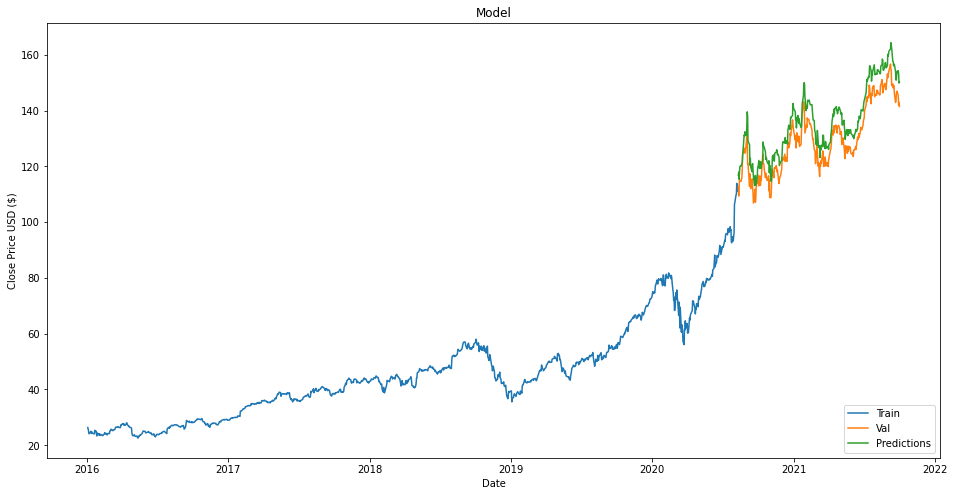

In [17]:
evaluate(y_test, y_predicted, '30 Steps')
prediction_visualization(y_predicted)

**Performace Comparison**

In [18]:
di = {'Name': title_name, 'Accuracy': acc, 'F-Score': r2_score, 'MAE': mae, 'MSE': mse}
result_df = pd.DataFrame(di)
print(result_df)

       Name  Accuracy   F-Score       MAE        MSE
0  60 Steps     89.39  0.933517  2.421162   9.252822
1  30 Steps     88.34  0.661765  6.368206  47.074216


In [20]:
fig = px.bar(result_df, 
             x='Name', 
             y='Accuracy')
fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    legend_title='',
    title = "Accuracy of Models"
)
fig.update_xaxes(title_font_family="Times New Roman", title='Models')
fig.update_yaxes(title_font_family="Times New Roman", title='Accuracy')
                  
fig.show()